# Skillbox — Мастер-класс: Разведочный анализ данных + Подготовка отчётов — Kiva.org
***

# Новый раздел

# 4. Домашнее задание
***

In [1]:
import numpy as np
import pandas as pd
import math
import missingno as msno
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Set2')

import os

In [2]:
df_kiva_loans = pd.read_csv("../EDA/kiva_loans.csv")
df_mpi = pd.read_csv("../EDA/kiva_mpi_region_locations.csv")

In [3]:
df_kiva_loans.head(5)

,id,funded_amount,loan_amount,activity,sector,use,country_code,country,region,currency,partner_id,posted_time,disbursed_time,funded_time,term_in_months,lender_count,tags,borrower_genders,repayment_interval,date
0,653051,300.0,300.0,Fruits & Vegetables,Food,"To buy seasonal, fresh fruits to sell.",PK,Pakistan,Lahore,PKR,247.0,2014-01-01 06:12:39+00:00,2013-12-17 08:00:00+00:00,2014-01-02 10:06:32+00:00,12.0,12,NaN,female,irregular,2014-01-01
1,653053,575.0,575.0,Rickshaw,Transportation,to repair and maintain the auto rickshaw used ...,PK,Pakistan,Lahore,PKR,247.0,2014-01-01 06:51:08+00:00,2013-12-17 08:00:00+00:00,2014-01-02 09:17:23+00:00,11.0,14,NaN,"female, female",irregular,2014-01-01
2,653068,150.0,150.0,Transportation,Transportation,To repair their old cycle-van and buy another ...,IN,India,Maynaguri,INR,334.0,2014-01-01 09:58:07+00:00,2013-12-17 08:00:00+00:00,2014-01-01 16:01:36+00:00,43.0,6,"user_favorite, user_favorite",female,bullet,2014-01-01
3,653063,200.0,200.0,Embroidery,Arts,to purchase an embroidery machine and a variet...,PK,Pakistan,Lahore,PKR,247.0,2014-01-01 08:03:11+00:00,2013-12-24 08:00:00+00:00,2014-01-01 13:00:00+00:00,11.0,8,NaN,female,irregular,2014-01-01
4,653084,400.0,400.0,Milk Sales,Food,to purchase one buffalo.,PK,Pakistan,Abdul Hakeem,PKR,245.0,2014-01-01 11:53:19+00:00,2013-12-17 08:00:00+00:00,2014-01-01 19:18:51+00:00,14.0,16,NaN,female,monthly,2014-01-01


In [53]:
df_mpi.head(5)

,LocationName,ISO,country,region,world_region,MPI,geo,lat,lon
0,"Badakhshan, Afghanistan",AFG,Afghanistan,Badakhshan,South Asia,0.387,"(36.7347725, 70.81199529999999)",36.734772,70.811995
1,"Badghis, Afghanistan",AFG,Afghanistan,Badghis,South Asia,0.466,"(35.1671339, 63.7695384)",35.167134,63.769538
2,"Baghlan, Afghanistan",AFG,Afghanistan,Baghlan,South Asia,0.300,"(35.8042947, 69.2877535)",35.804295,69.287754
3,"Balkh, Afghanistan",AFG,Afghanistan,Balkh,South Asia,0.301,"(36.7550603, 66.8975372)",36.755060,66.897537
4,"Bamyan, Afghanistan",AFG,Afghanistan,Bamyan,South Asia,0.325,"(34.8100067, 67.8212104)",34.810007,67.821210


## 4.1. Самостоятельная работа
***

- А в каких странах преобладают мужчины? Группа людей? (п. 2.2.2.)
- Изучите несколько займов с очень большими суммами. Что можно сказать о назначении этих заявок? В каких странах они оформлены? Каков гендерный состав заявителей? (п. 2.4.2.)
- Попробуйте найти связь между странами (регионами), полом заёмщика и суммой заявки. Какие выводы можно сделать из этих данных? (п. 2.4.3.)

## А в каких странах преобладают мужчины? Группа людей? (п. 2.2.2.)

In [5]:
countries = df_kiva_loans['country'].value_counts()[df_kiva_loans['country'].value_counts(normalize=True)> 0.005]
df_kiva_loans['borrower_genders'] = [elem if elem in ['female','male'] \
                                     else 'group' for elem in df_kiva_loans['borrower_genders'] ]

df_gender_by_country = \
    df_kiva_loans[df_kiva_loans['country'].isin(countries.index.values)]\
    .groupby(['country', 'borrower_genders'])['borrower_genders']\
    .count()\
    .groupby(level=0).apply(lambda x: 100 * x / x.sum())\
    .unstack('borrower_genders')\
    .fillna(0)\
    .sort_values(by=['male', 'group'])[-20:]

df_gender_by_country = df_gender_by_country[['male', 'group', 'female']]

df_gender_by_country.sort_values('male', ascending = False).head(5)

borrower_genders,male,group,female
country,,,
Nigeria,87.134964,0.878058,11.986977
Palestine,64.601445,0.183666,35.214889
Uganda,48.701519,11.421776,39.876705
Mozambique,48.377835,0.717772,50.904393
United States,42.294436,2.724438,54.981126


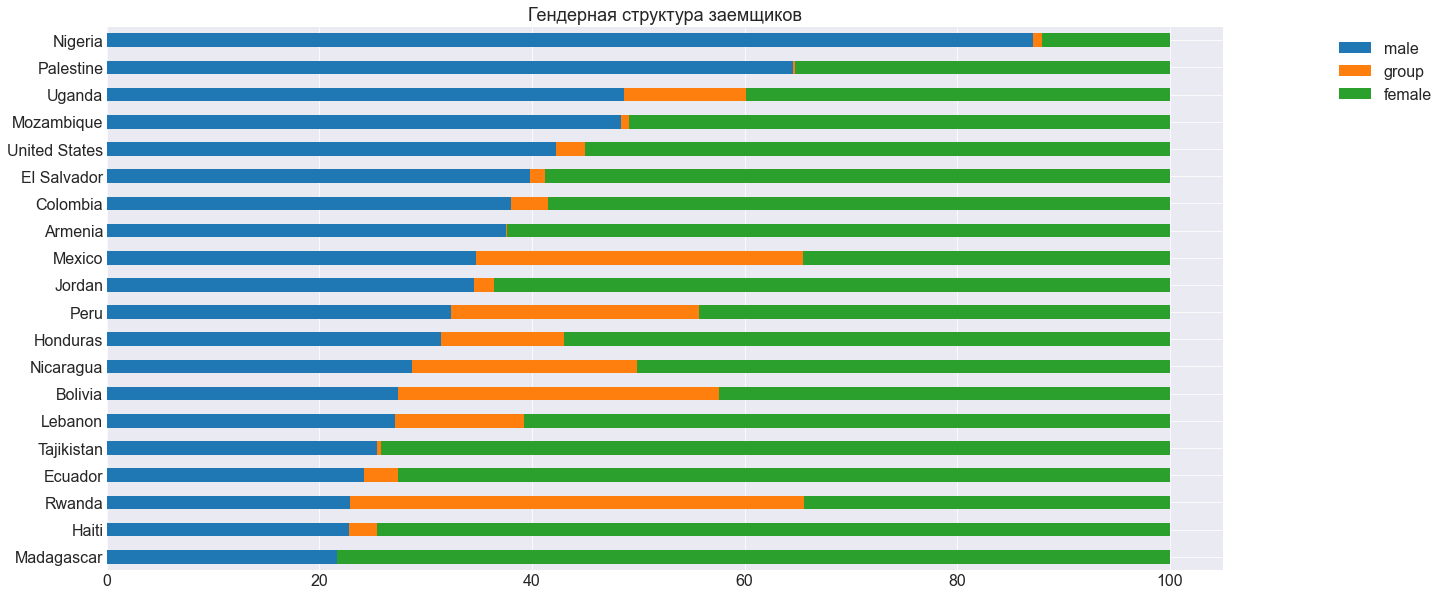

In [6]:
plot = df_gender_by_country.plot.barh(
        figsize=(20,10)
        , fontsize=16
        , stacked=True
        , title='Гендерная структура заемщиков')
plot.title.set_size(18)
plot.legend(loc=1, bbox_to_anchor=(1.2, 1), fontsize=16)
plot.set(ylabel=None, xlabel=None)
plt.show()

In [7]:
df_gender_by_country = \
    df_kiva_loans[df_kiva_loans['country'].isin(countries.index.values)]\
    .groupby(['country', 'borrower_genders'])['borrower_genders']\
    .count()\
    .groupby(level=0).apply(lambda x: 100 * x / x.sum())\
    .unstack('borrower_genders')\
    .fillna(0)\
    .sort_values(by=['group', 'male'])[-20:]

df_gender_by_country = df_gender_by_country[['group', 'male', 'female']]
df_gender_by_country.sort_values('group', ascending = False).head(5)

borrower_genders,group,male,female
country,,,
Mali,91.836120,4.835066,3.328815
Cambodia,73.682398,5.368010,20.949592
Guatemala,62.640219,20.314637,17.045144
Tanzania,59.149262,10.346810,30.503928
Ghana,57.933242,16.095107,25.971651


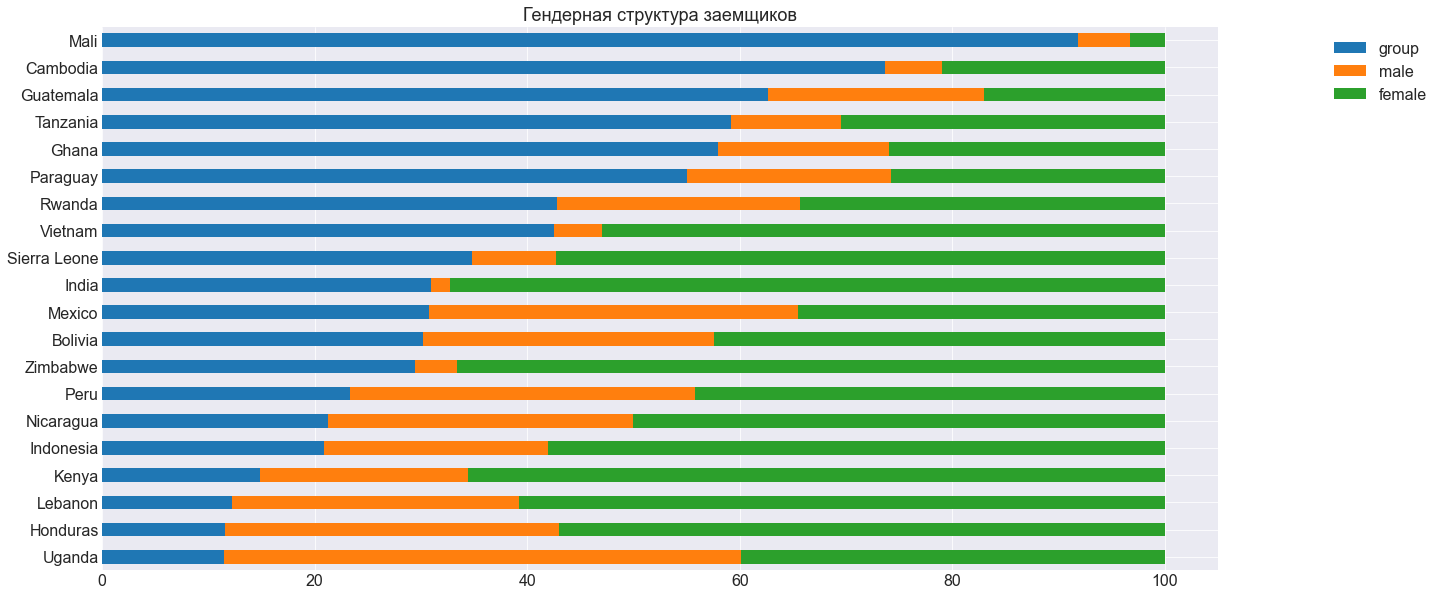

In [8]:
plot = df_gender_by_country.plot.barh(
        figsize=(20,10)
        , fontsize=16
        , stacked=True
        , title='Гендерная структура заемщиков')
plot.title.set_size(18)
plot.legend(loc=1, bbox_to_anchor=(1.2, 1), fontsize=16)
plot.set(ylabel=None, xlabel=None)
plt.show()

## Изучите несколько займов с очень большими суммами. Что можно сказать о назначении этих заявок? В каких странах они оформлены? Каков гендерный состав заявителей? (п. 2.4.2.)

In [9]:
big_loan_amount = df_kiva_loans[df_kiva_loans['loan_amount'] > 20000]

big_loan_amount = big_loan_amount.sort_values('loan_amount', ascending = False)[['loan_amount', 'activity',\
                                'sector', 'use', 'country', 'borrower_genders']]
big_loan_amount.head(5)

,loan_amount,activity,sector,use,country,borrower_genders
70499,100000.0,Agriculture,Agriculture,create more than 300 jobs for women and farmer...,Haiti,female
34196,50000.0,Renewable Energy Products,Retail,to buy and sell Barefoot Power's Solar Lightin...,Peru,male
526100,50000.0,Renewable Energy Products,Retail,to distribute 200+ innovative & affordable pay...,Zambia,male
544548,50000.0,Health,Health,to provide community trauma services in South ...,South Sudan,female
541006,50000.0,Goods Distribution,Wholesale,to bolster logistics of affordable water distr...,Haiti,male


In [10]:
activity = big_loan_amount['activity'].value_counts()
activity.head(5)

Agriculture                  29
Renewable Energy Products    19
Goods Distribution            3
Education provider            3
Taxi                          3
Name: activity, dtype: int64

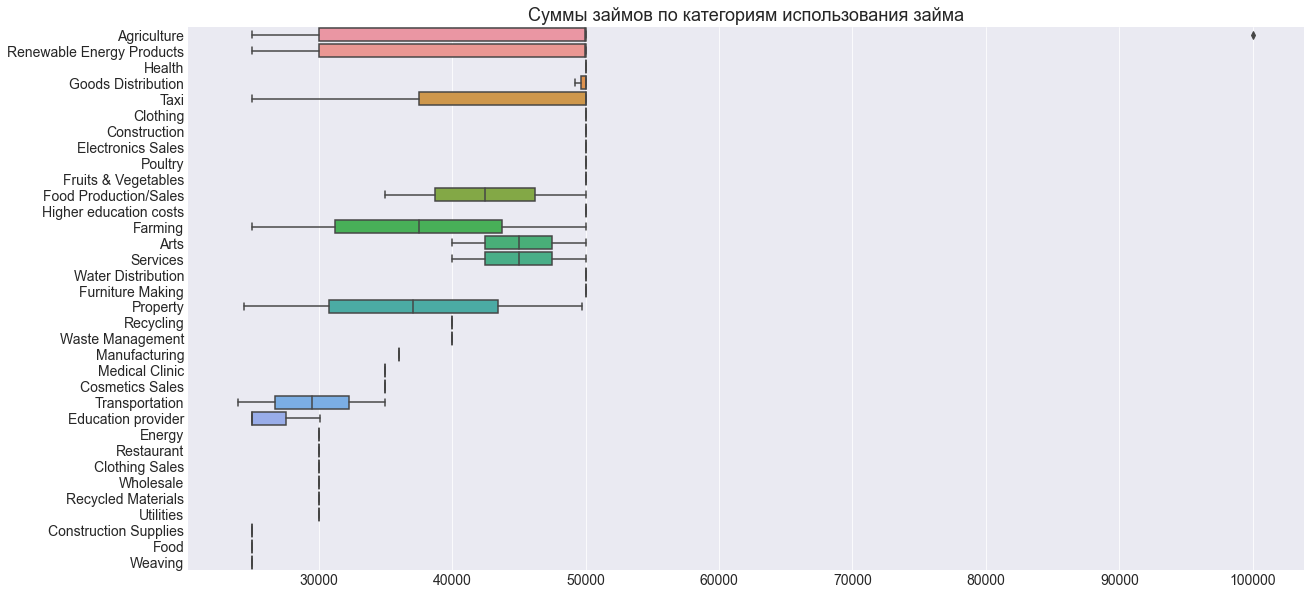

In [11]:
plt.figure(figsize=(20,10))
plt.title("Суммы займов по категориям использования займа", fontsize=18)
plt.xticks(np.arange(0, max(big_loan_amount['loan_amount']+1), 10000))
plt.tick_params(labelsize=14)

sns.boxplot(x='loan_amount', y="activity", data=big_loan_amount).set(ylabel=None, xlabel=None)
plt.show()

In [12]:
sector = big_loan_amount['sector'].value_counts()
sector.head(5)

Agriculture       32
Retail            22
Services           8
Transportation     5
Food               5
Name: sector, dtype: int64

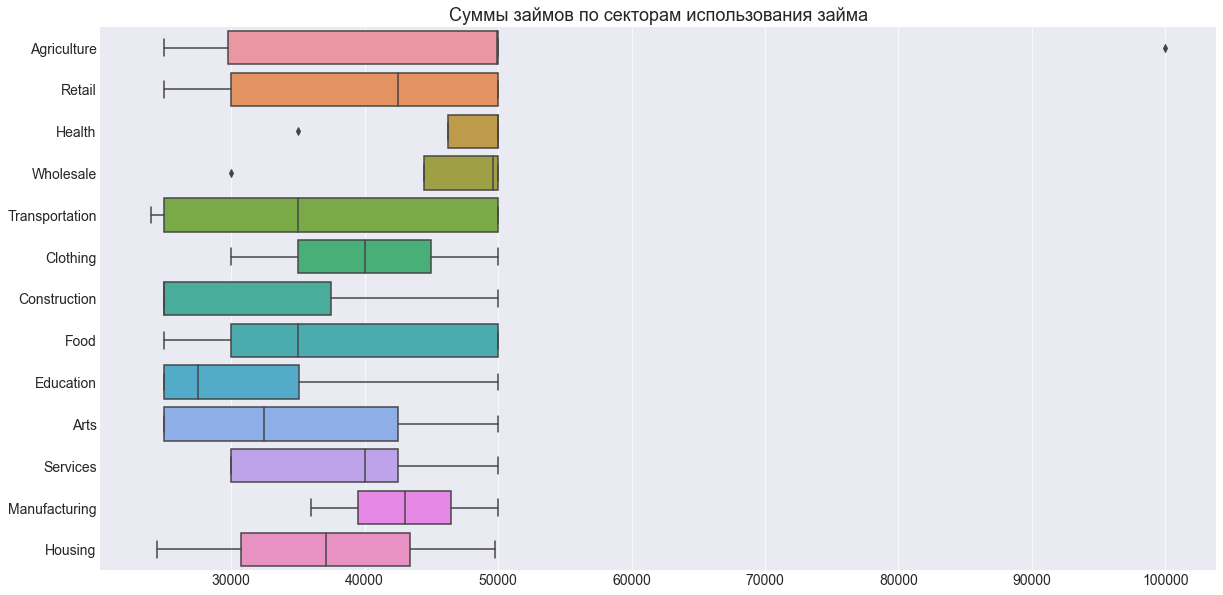

In [13]:
plt.figure(figsize=(20,10))
plt.title("Суммы займов по секторам использования займа", fontsize=18)
plt.xticks(np.arange(0, max(big_loan_amount['loan_amount']+1), 10000))
plt.tick_params(labelsize=14)

sns.boxplot(x='loan_amount', y="sector", data=big_loan_amount).set(ylabel=None, xlabel=None)
plt.show()

In [14]:
big_loan_amount[big_loan_amount['sector'] == 'Retail']

,loan_amount,activity,sector,use,country,borrower_genders
34196,50000.0,Renewable Energy Products,Retail,to buy and sell Barefoot Power's Solar Lightin...,Peru,male
526100,50000.0,Renewable Energy Products,Retail,to distribute 200+ innovative & affordable pay...,Zambia,male
523659,50000.0,Electronics Sales,Retail,to train & equip 200 rural merchants in Mozamb...,Mozambique,female
548513,50000.0,Renewable Energy Products,Retail,to distribute solar home systems throughout ru...,Zimbabwe,male
563074,50000.0,Renewable Energy Products,Retail,to provide life-changing clean cookstoves and ...,Kenya,female
43182,50000.0,Renewable Energy Products,Retail,To buy and sell Barefoot Power's solar lightin...,Kenya,male
53634,50000.0,Renewable Energy Products,Retail,To buy and sell Barefoot Power solar lighting.,Uganda,female
660807,50000.0,Renewable Energy Products,Retail,to distribute 400 pay-as-you-go solar systems ...,Pakistan,female
621860,50000.0,Renewable Energy Products,Retail,to distribute 400 pay-as-you-go solar home sys...,Kenya,male
586970,50000.0,Renewable Energy Products,Retail,to generate income to over 600 fishermen in Ta...,Tanzania,female


In [15]:
big_loan_amount[big_loan_amount['sector'] == 'Agriculture']

,loan_amount,activity,sector,use,country,borrower_genders
70499,100000.0,Agriculture,Agriculture,create more than 300 jobs for women and farmer...,Haiti,female
538248,50000.0,Agriculture,Agriculture,"to enable 5,000 additional small-holder farmer...",Kenya,male
447374,50000.0,Agriculture,Agriculture,to increase smallholder farmers’ incomes by bu...,Uganda,male
494470,50000.0,Agriculture,Agriculture,To pay smallholder coffee farmers in rural Ken...,Kenya,female
509048,50000.0,Poultry,Agriculture,to purchase chicken feed & a delivery vehicle ...,Tanzania,female
492809,50000.0,Agriculture,Agriculture,"to expand weather, farming information and fin...",Ghana,male
618264,50000.0,Farming,Agriculture,to provide income opportunities in remote Indo...,Indonesia,male
631904,50000.0,Agriculture,Agriculture,double cashew nut export output and hire about...,Cote D'Ivoire,female
126839,50000.0,Agriculture,Agriculture,to buy and plant resin producing pine trees. T...,Mexico,group
163727,50000.0,Agriculture,Agriculture,to fund its growing loan book and further deve...,Kenya,female


In [16]:
big_loan_amount[big_loan_amount['sector'] == 'Transportation']

,loan_amount,activity,sector,use,country,borrower_genders
375404,50000.0,Taxi,Transportation,NaN,Mexico,group
383723,50000.0,Taxi,Transportation,to generate USD1.2mm in fuel savings and impac...,Mexico,male
129849,35000.0,Transportation,Transportation,to purchase a truck to deliver water filters t...,Lao People's Democratic Republic,male
420511,25000.0,Taxi,Transportation,"to equip 75 taxis with natural gas engines, th...",Mexico,male
243401,24000.0,Transportation,Transportation,to purchase a delivery truck to deliver water ...,Lao People's Democratic Republic,male


In [17]:
country = big_loan_amount['country'].value_counts()
country.head(5)

Kenya     14
Peru      12
Mexico    12
Uganda     7
Haiti      6
Name: country, dtype: int64

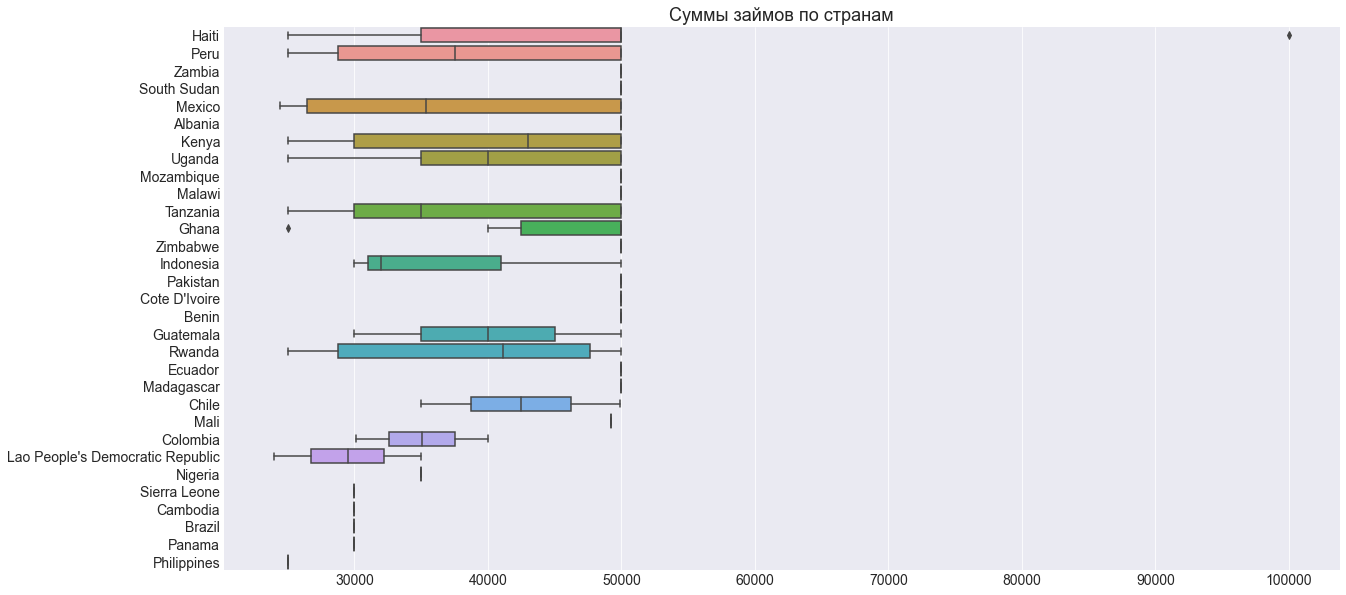

In [18]:
plt.figure(figsize=(20,10))
plt.title("Суммы займов по странам", fontsize=18)
plt.xticks(np.arange(0, max(big_loan_amount['loan_amount']+1), 10000))
plt.tick_params(labelsize=14)

sns.boxplot(x='loan_amount', y="country", data=big_loan_amount).set(ylabel=None, xlabel=None)
plt.show()

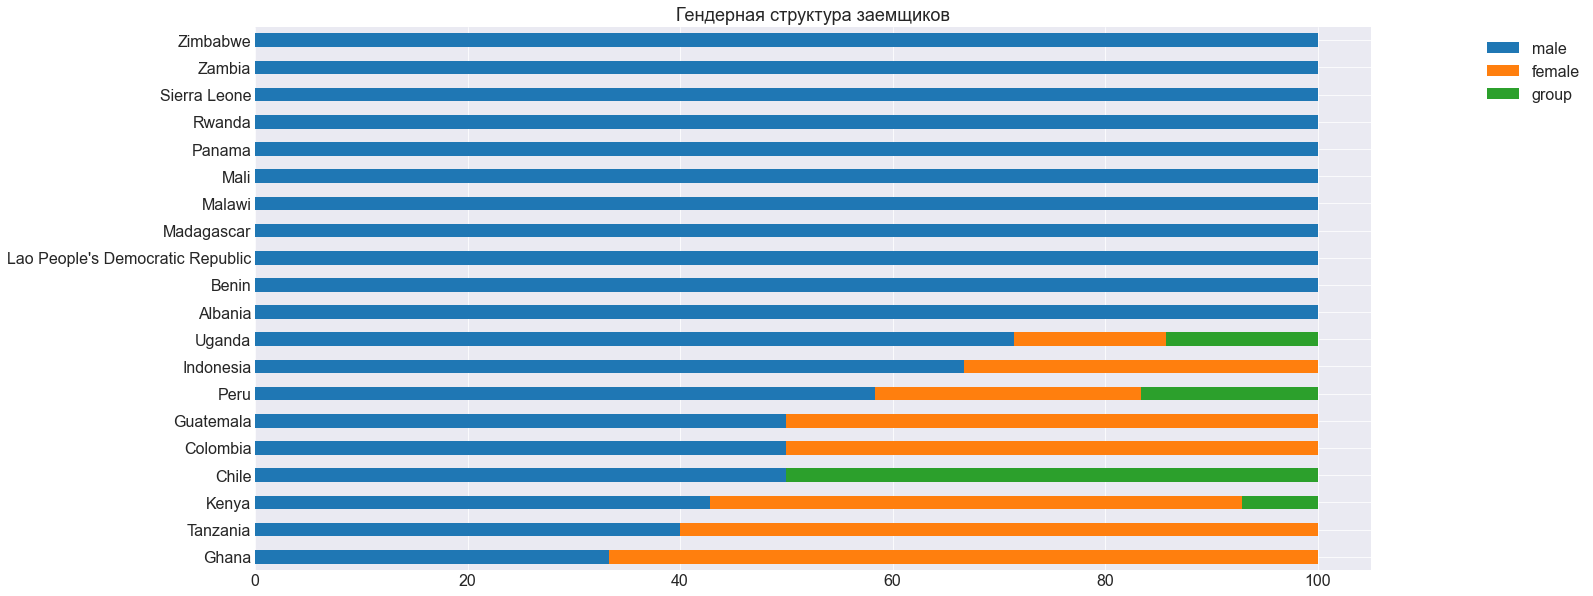

In [19]:
countries = big_loan_amount['country'].value_counts()[big_loan_amount['country'].value_counts(normalize=True)> 0.005]
big_loan_amount['borrower_genders'] = [elem if elem in ['female','male'] \
                                     else 'group' for elem in big_loan_amount['borrower_genders'] ]

big_loan_amount_by_gender = \
    big_loan_amount[big_loan_amount['country'].isin(countries.index.values)]\
    .groupby(['country', 'borrower_genders'])['borrower_genders']\
    .count()\
    .groupby(level=0).apply(lambda x: 100 * x / x.sum())\
    .unstack('borrower_genders')\
    .fillna(0)\
    .sort_values(by=['male', 'female'])[-20:]

big_loan_amount_by_gender = big_loan_amount_by_gender[['male','female', 'group']]

plot = big_loan_amount_by_gender.plot.barh(
        figsize=(20,10)
        , fontsize=16
        , stacked=True
        , title='Гендерная структура заемщиков')
plot.title.set_size(18)
plot.legend(loc=1, bbox_to_anchor=(1.2, 1), fontsize=16)
plot.set(ylabel=None, xlabel=None)
plt.show()

Большая часть заявок с крупными суммами связана с формированием в сельском хозяйстве новых рабочих мест, улучшению финансирования мелких фермерских хозяйств в секторе "Сельское хозяйство" и организацией розничной торговли в сфере возобновляемых источников энергии, в частности солнечных панелей.
В основном заявки подаются из "кофейных стран" Кения, Мексика, Перу. Часть заявок связана с производством кофейных зерен.
Основные заемщики мужчины, групповые заявки не преобладают.

## Попробуйте найти связь между странами (регионами), полом заёмщика и суммой заявки. Какие выводы можно сделать из этих данных? (п. 2.4.3.)

In [20]:
df_mpi_grouped = df_mpi\
    .groupby(['ISO', 'country', 'world_region'])['MPI']\
    .mean()\
    .fillna(0)\
    .reset_index()

df_kiva_loans = df_kiva_loans.merge(df_mpi_grouped, how='left', on='country')

regions = df_kiva_loans['world_region'].value_counts()

regions_list = regions.index.to_list()


In [21]:
dev = (df_kiva_loans['loan_amount']-df_kiva_loans['loan_amount'].mean()).abs()
std = df_kiva_loans['loan_amount'].std()
df_kiva_loans_trimmed = df_kiva_loans[~(dev>3*std)]


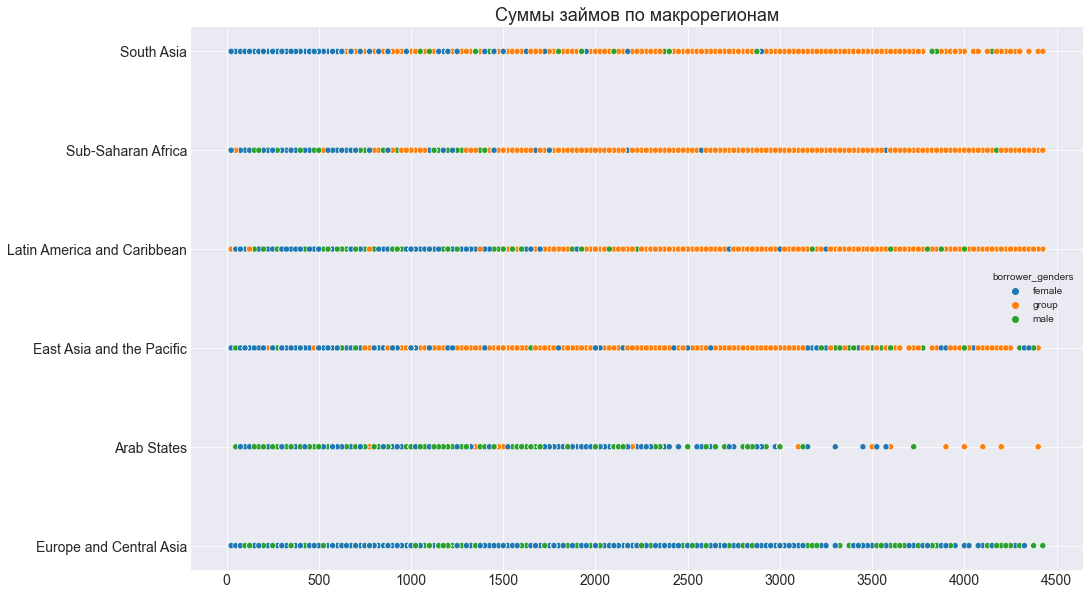

In [22]:
plt.figure(figsize=(16,10))
plt.title("Суммы займов по макрорегионам", fontsize=18)
plt.xticks(np.arange(0, max(df_kiva_loans['loan_amount']+1), 500))
plt.tick_params(labelsize=14)

sns.scatterplot(x='loan_amount', y="world_region", hue = 'borrower_genders',  data=df_kiva_loans_trimmed)\
    .set(ylabel=None, xlabel=None)
# plt.legend(loc=1, bbox_to_anchor=(1.15, 1), fontsize=16)
plt.show()

Только в более развитых странах Европы и Центральной Азии большие суммы займов оформляют женщины в равной степени с мужчинами.
В Арабских странах женщины из-за исторически сложившейся ситуации займы почти не делают, если и делают, то не большие, в основной массе займов это мужчины.
В Южной Азии небольшие займы берут только женщины, суммы побольше практически все берут только группы лиц.
В остальных странах преобладание групповых займов среди крупных сумм, небольшие суммы берут и женщины и мужчины.

## 4.2. Домашняя работа
***

Расширьте наш отчёт исследованием следующих вопросов:

- Зависимость пола заёмщика от региона планеты, сектора экономики.
- Влияние такого атрибута займа, как **Количество кредиторов** (lender_count), на суммы и сроки займов.
- Влияние показателя **MPI** (многомерный индекс бедности) в разных странах на суммы займов и сроки погашения.
- Зависимости таких метрик, как «Сумма займа», «Срок займа», «Время финансирования заявки», «Ежемесячный платёж», в разрезе **макрорегионов**.

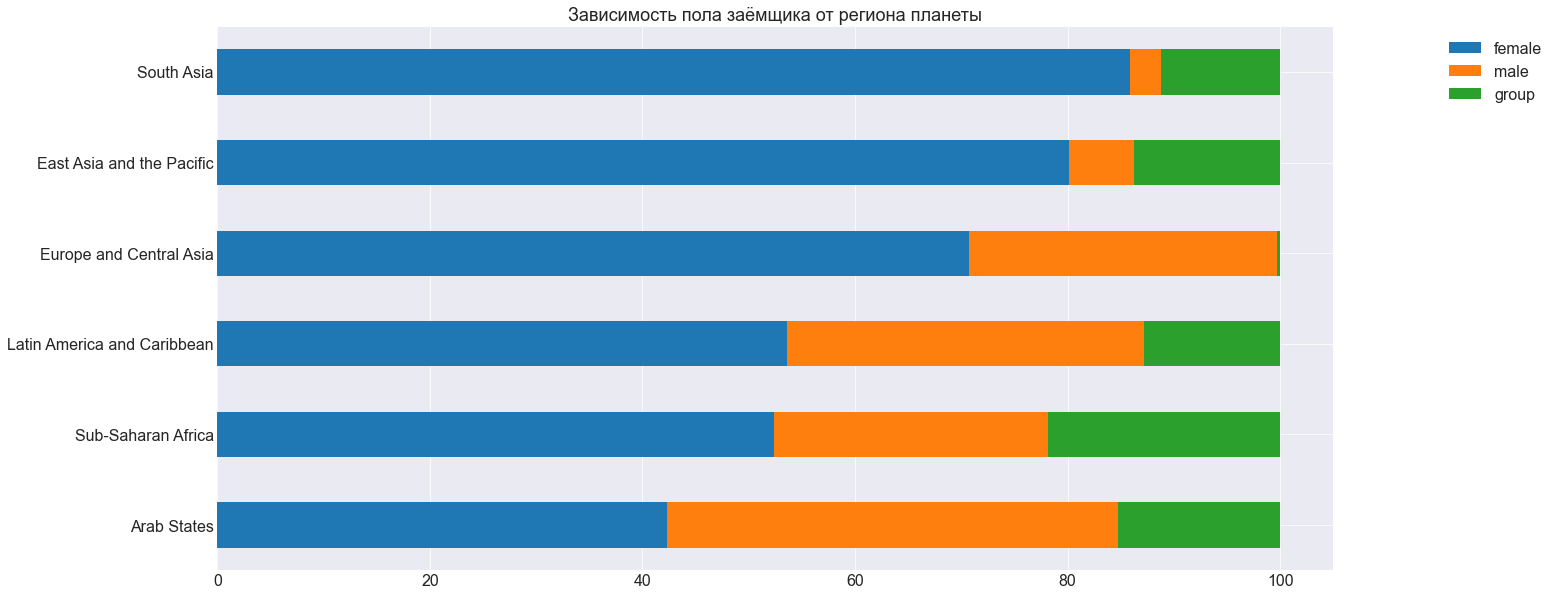

In [23]:
df_gender_region = \
    df_kiva_loans\
    .groupby(['world_region', 'borrower_genders'])['borrower_genders']\
    .count()\
    .groupby(level=0).apply(lambda x: 100 * x / x.sum())\
    .unstack('borrower_genders')\
    .fillna(0)\
    .sort_values(by=['female', 'male'])




df_gender_region = df_gender_region[['female', 'male', 'group']]

plot = df_gender_region.plot.barh(
        figsize=(20,10)
        , fontsize=16
        , stacked=True
        , title='Зависимость пола заёмщика от региона планеты')
plot.title.set_size(18)
plot.legend(loc=1, bbox_to_anchor=(1.2, 1), fontsize=16)
plot.set(ylabel=None, xlabel=None)
plt.show()

Больше всего займов берут женщины. Причем больше всего в странах Восточной Азии и Тихого океана, меньше всего женщины берут займы в Арабских странах. Групповых займов делают меньше и среди них большинство опять-таки в странах Южной Африки и Восточной Азии. Мужчины чаще всего занимают в странах Южной Африки и Латинской Америки.

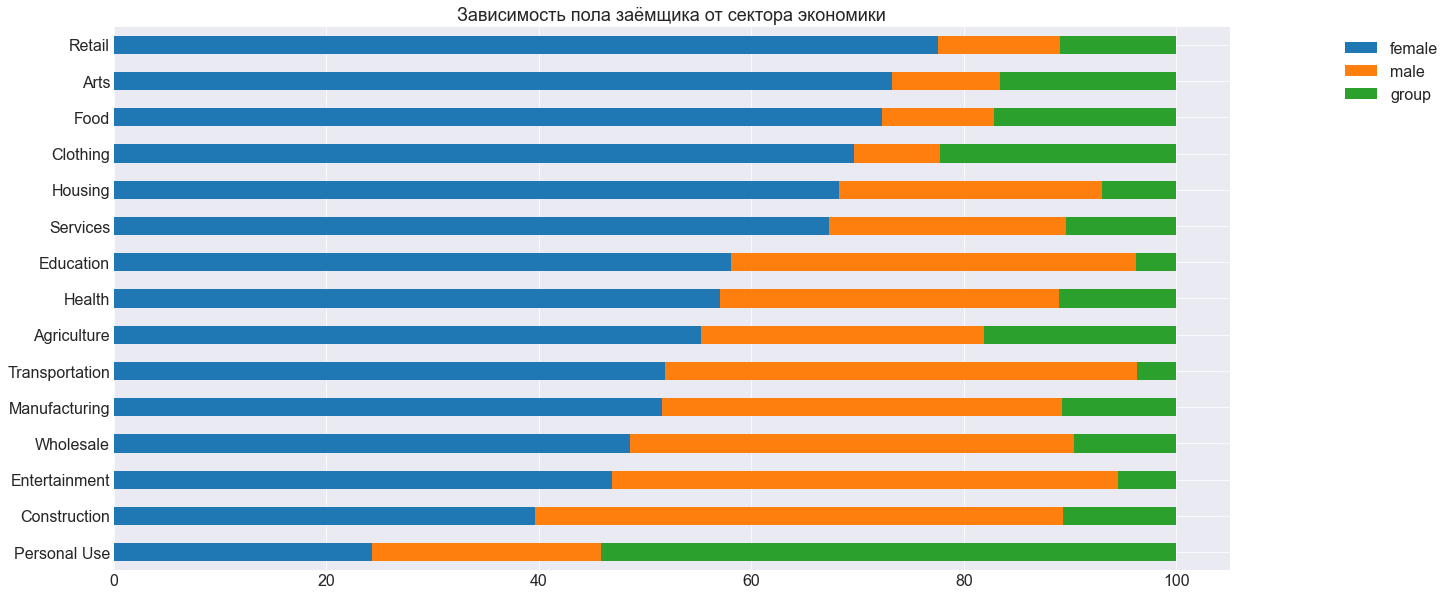

In [24]:
df_gender_sector = \
    df_kiva_loans\
    .groupby(['sector', 'borrower_genders'])['borrower_genders']\
    .count()\
    .groupby(level=0).apply(lambda x: 100 * x / x.sum())\
    .unstack('borrower_genders')\
    .fillna(0)\
    .sort_values(by=['female', 'male'])




df_gender_sector = df_gender_sector[['female', 'male', 'group']]

plot = df_gender_sector.plot.barh(
        figsize=(20,10)
        , fontsize=16
        , stacked=True
        , title='Зависимость пола заёмщика от сектора экономики')
plot.title.set_size(18)
plot.legend(loc=1, bbox_to_anchor=(1.2, 1), fontsize=16)
plot.set(ylabel=None, xlabel=None)
plt.show()

Женщины чаще всего берут займы в таких секторах экономики как: Еда, Сельское хозяйство и Одежда.
Мужчины, - в основном в Сельском хозяйстве, группы, - в Еде, Сельском хозяйстве и на собственные нужды. 

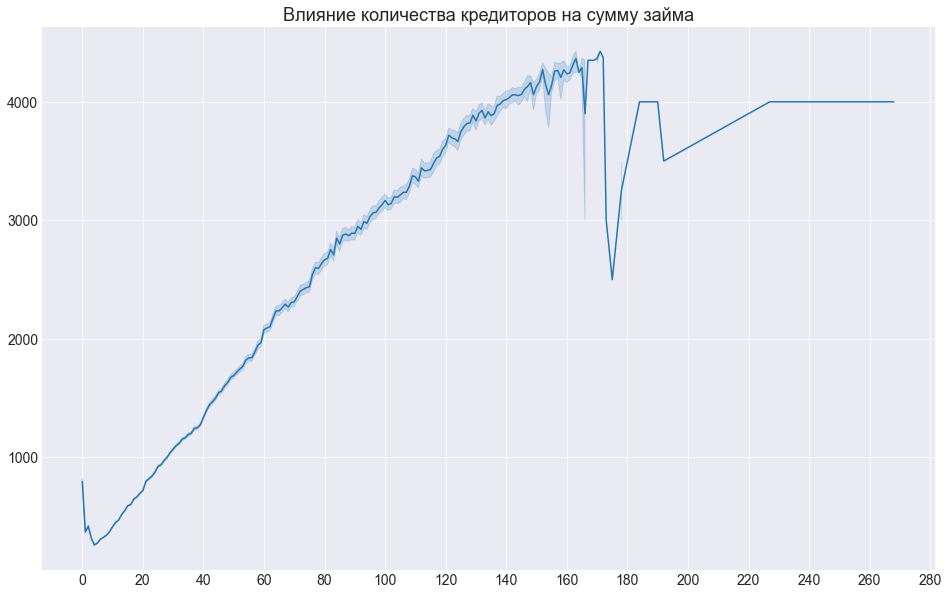

In [39]:
#Влияние такого атрибута займа, как Количество кредиторов (lender_count), на суммы и сроки займов.


plt.figure(figsize=(16,10))
plt.title("Влияние количества кредиторов на сумму займа", fontsize=18)
plt.xticks(np.arange(0, max(df_kiva_loans['lender_count']+1), 20))
plt.tick_params(labelsize=14)

sns.lineplot(x='lender_count', y="loan_amount",  data=df_kiva_loans_trimmed)\
    .set(ylabel=None, xlabel=None)
# plt.legend(loc=1, bbox_to_anchor=(1.15, 1), fontsize=16)
plt.show()

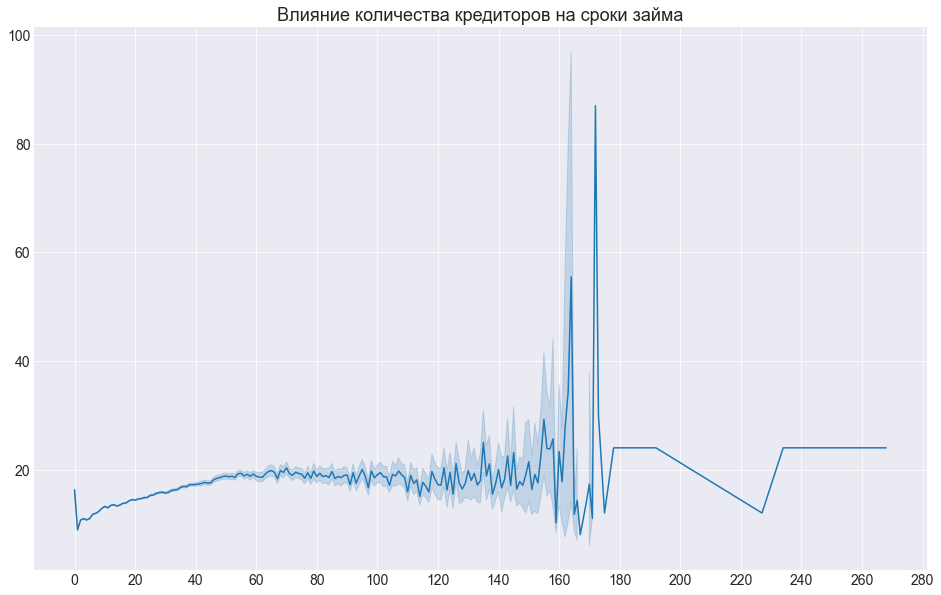

In [40]:
plt.figure(figsize=(16,10))
plt.title("Влияние количества кредиторов на сроки займа", fontsize=18)
plt.xticks(np.arange(0, max(df_kiva_loans['lender_count']+1), 20))
plt.tick_params(labelsize=14)

sns.lineplot(x='lender_count', y="term_in_months",  data=df_kiva_loans_trimmed)\
    .set(ylabel=None, xlabel=None)
# plt.legend(loc=1, bbox_to_anchor=(1.15, 1), fontsize=16)
plt.show()

Начиная с 160 заемщиков наблюдается пик выдаваемой суммы и длительность сроков выдачи кредита

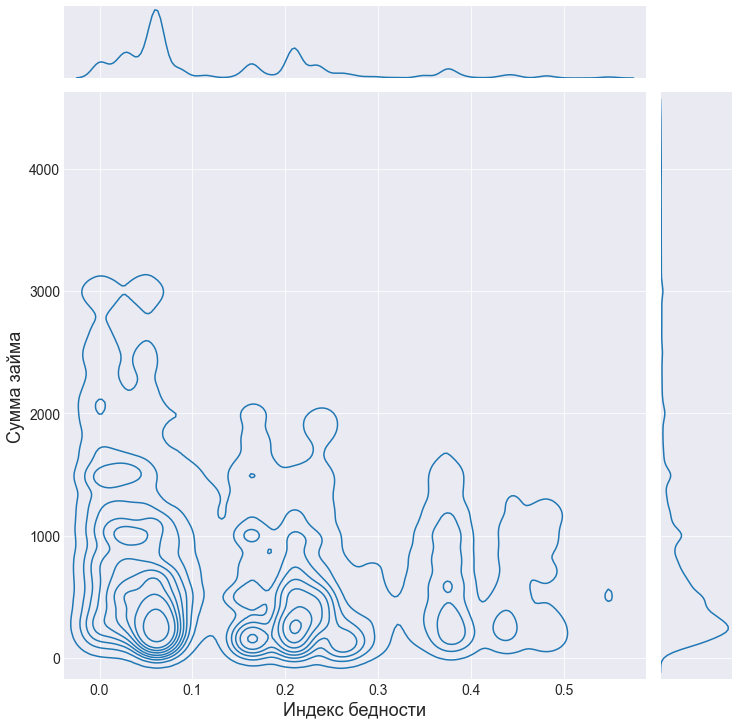

In [50]:
#Влияние показателя MPI (многомерный индекс бедности) в разных странах на суммы займов и сроки погашения.

p = sns.jointplot(x="MPI", y="loan_amount", data=df_kiva_loans_trimmed, kind='kde', height=10, ratio=7)\
        .set_axis_labels("Индекс бедности", "Сумма займа", size=18)

# p.ax_joint.set_xticks(np.arange(0, max(df_loans_dates_trimmed['time_funding']+1), 5))
# p.ax_joint.set_yticks(np.arange(0, max(df_loans_dates_trimmed['loan_amount']+1), 250))
p.ax_joint.tick_params(labelsize=14)

plt.show()

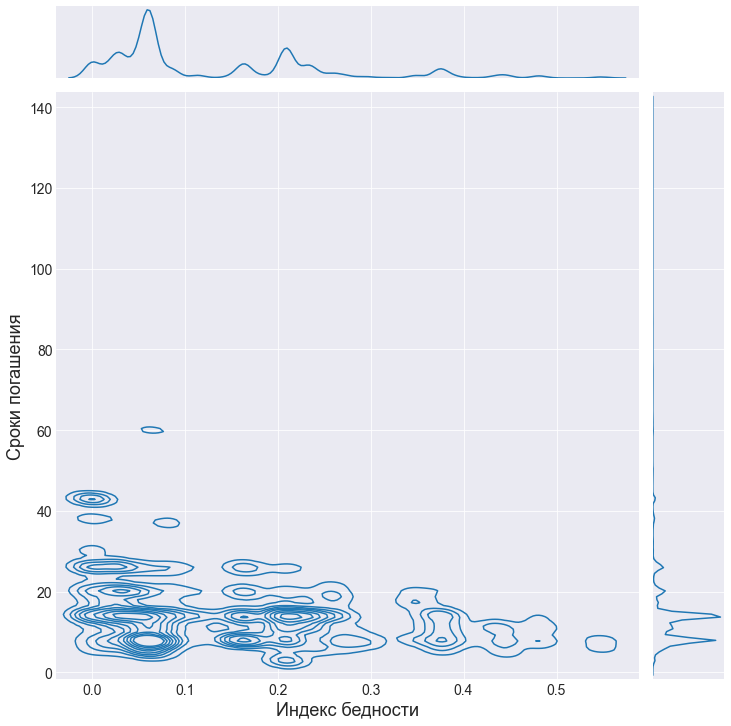

In [51]:
p = sns.jointplot(x="MPI", y="term_in_months", data=df_kiva_loans_trimmed, kind='kde', height=10, ratio=7)\
        .set_axis_labels("Индекс бедности", "Сроки погашения", size=18)

# p.ax_joint.set_xticks(np.arange(0, max(df_loans_dates_trimmed['time_funding']+1), 5))
# p.ax_joint.set_yticks(np.arange(0, max(df_loans_dates_trimmed['loan_amount']+1), 250))
p.ax_joint.tick_params(labelsize=14)

plt.show()

Чем ниже индекс бедности тем большие суммы и на больший срок берут заемщики.

Зависимости таких метрик, как «Сумма займа», «Срок займа», «Время финансирования заявки», «Ежемесячный платёж», в разрезе макрорегионов

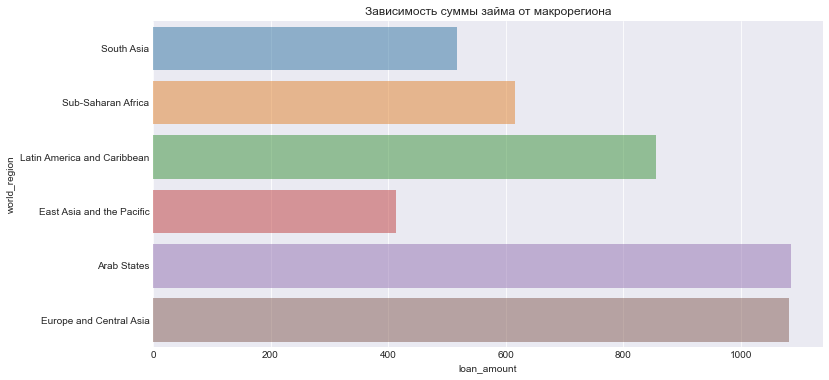

In [63]:
fig, ax = plt.subplots(figsize = (12, 6))
sns.barplot(data = df_kiva_loans_trimmed , x = 'loan_amount', y = 'world_region', ax = ax, ci = None, alpha = 0.5 )
ax.set_title('Зависимость суммы займа от макрорегиона')
plt.show()

Наибольшие суммы займа берут в Европе и Центральной Азии и в Арабских странах

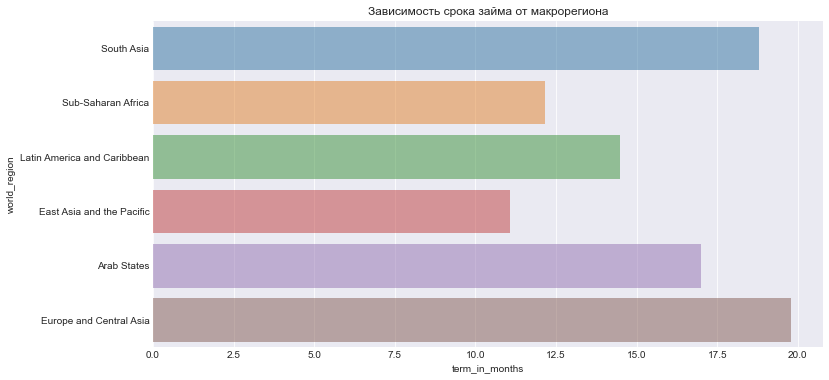

In [62]:
fig, ax = plt.subplots(figsize = (12, 6))
sns.barplot(data = df_kiva_loans_trimmed , x = 'term_in_months', y = 'world_region', ax = ax, ci = None, alpha = 0.5 )
ax.set_title('Зависимость срока займа от макрорегиона')
plt.show()

In [ ]:
На более долгие сроки берут кредит в Европе и Центральной Азии (но там и сумма кредита больше) и в Южной Азии

C:\Users\persi\anaconda3\lib\site-packages\pandas\core\frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
C:\Users\persi\anaconda3\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\persi\anaconda3\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

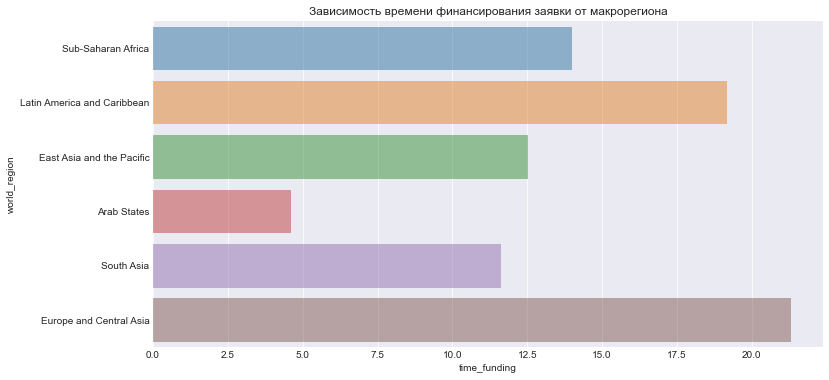

In [65]:
df_loans_dates = df_kiva_loans_trimmed.dropna(subset=['disbursed_time', 'funded_time'], how='any', inplace=False)

# dates columns:
dates = ['posted_time','disbursed_time']

# format dates:
df_loans_dates[dates] = df_loans_dates[dates].applymap(lambda x : x.split('+')[0])
df_loans_dates[dates] = df_loans_dates[dates].apply(pd.to_datetime)

# calculate time interval
df_loans_dates.loc[:, 'time_funding'] = df_loans_dates['disbursed_time']-df_loans_dates['posted_time']
df_loans_dates.loc[:, 'time_funding'] = df_loans_dates['time_funding'] / timedelta(days=1) 

# remove outliers +-3 sigma
dev = (df_loans_dates['time_funding']-df_loans_dates['time_funding'].mean()).abs()
std = df_loans_dates['time_funding'].std()
# Keep rows where time_funding interval > 0 only
df_loans_dates_trimmed = df_loans_dates[~(dev>3*std) & (df_loans_dates.loc[:, 'time_funding']>0)]

fig, ax = plt.subplots(figsize = (12, 6))
sns.barplot(data = df_loans_dates_trimmed , x = 'time_funding', y = 'world_region', ax = ax, ci = None, alpha = 0.5 )
ax.set_title('Зависимость времени финансирования заявки от макрорегиона')
plt.show()

Дольше всего заявки на финансирование оформляются в Европе и Центральной Азии и в странах Латинской Америки, быстрее всего в Арабских странах

<ipython-input-66-81505e69eb6b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_kiva_loans_trimmed['monthly_repayment'] = df_kiva_loans_trimmed['loan_amount'] / df_kiva_loans_trimmed['term_in_months']


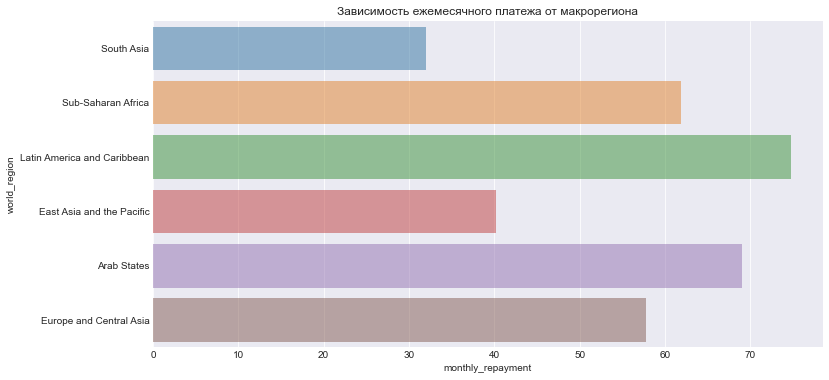

In [66]:
df_kiva_loans_trimmed['monthly_repayment'] = df_kiva_loans_trimmed['loan_amount'] / df_kiva_loans_trimmed['term_in_months']

fig, ax = plt.subplots(figsize = (12, 6))
sns.barplot(data = df_kiva_loans_trimmed , x = 'monthly_repayment', y = 'world_region', ax = ax, ci = None, alpha = 0.5 )
ax.set_title('Зависимость ежемесячного платежа от макрорегиона')
plt.show()

Самые большие ежемесячные платежи в странах Латинской Америки и Арабских странах, меньше всего в Восточной Азии